In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score

import seaborn as sns ; sns.set()
import matplotlib.pyplot as plt

import pickle

exec(open('justins_utils.py').read())
exec(open('justins_pipeline.py').read())

%matplotlib inline

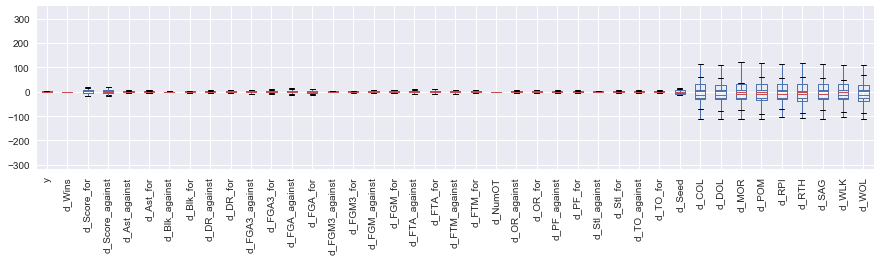

In [6]:
# read in raw dataframes
df_tr  = pd.read_csv('dataframes/post_results_tr.csv', index_col=0)
df_tst = pd.read_csv('dataframes/post_results_tst.csv', index_col=0)

# read in team_stats_all.csv, then merge into raw dataframes
team_stats_all = pd.read_csv('dataframes/team_stats_all.csv').set_index(['Season', 'TeamID'])
df_tr  = results_processing(df_tr, team_stats_all)
df_tst = results_processing(df_tst, team_stats_all)

# convert individual stats to difference stats
df_tr = individual_to_diff(df_tr)
df_tst = individual_to_diff(df_tst)

# sanity check: make sure distributions for features are similar in train and test sets
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
df_tr.plot.box(ax=ax, rot=90)
df_tst.plot.box(ax=ax, rot=90)

# Feature Selection

### Dropping Heavily Correlated Features

In [7]:
# these were determined during the data exploration phase
ordinals_to_drop = ['d_COL', 'd_DOL', 'd_POM', 'd_RPI', 'd_RTH', 'd_SAG', 'd_WLK', 'd_WOL']

# drop selected ordinal rankings
df_dropped     = df_tr.drop(columns=ordinals_to_drop)
df_dropped_tst = df_tst.drop(columns=ordinals_to_drop)

peek(df_dropped)
peek(df_dropped_tst)

dataframe shape = (914, 33)


,y,d_Wins,d_Score_for,d_Score_against,d_Ast_against,d_Ast_for,d_Blk_against,d_Blk_for,d_DR_against,d_DR_for,...,d_OR_against,d_OR_for,d_PF_against,d_PF_for,d_Stl_against,d_Stl_for,d_TO_against,d_TO_for,d_Seed,d_MOR
1136,0,0.151724,1.593103,-7.614943,-2.095402,1.165517,-1.641379,-0.766667,0.039080,1.627586,...,-1.790805,0.890805,2.943678,-0.803448,-0.827586,-0.635632,1.505747,-0.973563,0.0,28.206411
1137,1,0.237685,17.421182,7.112069,2.188424,3.435961,-1.262315,1.248768,1.423645,1.918719,...,3.520936,2.213054,4.140394,1.853448,-1.139163,1.602217,3.857143,0.716749,-15.0,-192.295543
1138,1,-0.172414,1.448276,3.344828,0.758621,-1.068966,0.758621,-0.827586,-3.034483,-2.655172,...,-1.344828,-0.379310,2.931034,0.655172,-1.275862,-2.172414,0.448276,0.206897,3.0,-7.745113
1139,1,-0.085684,0.102403,8.908046,-0.570533,-1.197492,-0.092999,-0.454545,-2.467085,0.094044,...,1.180773,-0.292581,2.295716,3.692790,2.114943,-1.290491,-0.991641,4.877743,5.0,85.008600
1140,1,0.124138,2.082759,1.758621,3.467816,1.333333,-0.316092,-0.273563,1.566667,2.345977,...,0.639080,1.508046,-0.229885,-1.563218,-1.502299,-1.214943,0.297701,-0.027586,-1.0,8.742768


dataframe shape = (67, 33)


,y,d_Wins,d_Score_for,d_Score_against,d_Ast_against,d_Ast_for,d_Blk_against,d_Blk_for,d_DR_against,d_DR_for,...,d_OR_against,d_OR_for,d_PF_against,d_PF_for,d_Stl_against,d_Stl_for,d_TO_against,d_TO_for,d_Seed,d_MOR
2050,1,0.012311,-10.928977,-10.966856,-0.943182,-0.592803,-0.509470,0.037879,-1.209280,-2.820076,...,1.275568,-1.172348,-1.486742,-2.366477,0.271780,2.349432,3.650568,1.248106,0.0,6.652174
2051,1,-0.048319,-2.426471,-0.840336,-1.460084,-3.924370,-0.878151,1.000000,4.640756,-0.560924,...,0.684874,-4.281513,-2.420168,0.392857,-2.212185,-1.186975,-0.659664,-3.424370,0.0,-48.798084
2052,0,0.108333,3.958333,-4.975000,-2.662500,1.133333,-0.835417,-0.233333,-0.906250,1.514583,...,2.297917,0.814583,-3.379167,-2.520833,-1.952083,0.304167,-0.695833,-1.954167,0.0,-23.866618
2053,0,-0.102273,-8.446970,-6.556818,-2.609848,-1.115530,-0.458333,-2.424242,0.696023,-0.740530,...,-1.860795,-1.819129,0.464015,1.215909,0.736742,-0.523674,1.150568,1.442235,0.0,-6.134119
2054,1,0.203782,-2.413866,-8.844538,1.039916,-0.955882,0.535714,0.413866,-4.691176,0.327731,...,-0.796218,1.329832,-0.598739,-4.457983,-1.978992,-2.142857,-2.873950,-2.344538,-13.0,-166.569639


In [8]:
# remaining operations require matrix input
X, y         = get_X_y(df_dropped)
X_tst, y_tst = get_X_y(df_dropped_tst)

X.shape      = (914, 32) 
y.shape      = (914,)
X.shape      = (67, 32) 
y.shape      = (67,)


### Recursive Feature Pruning
F-score analysis performed during data exploration revealed a few features that had little to no predictive power with respect to post-season wins.

In [ ]:
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
rfe = RFECV(model, step=1, cv=3, scoring='neg_log_loss')
rfe.fit(X, y)

X_rfe = rfe.transform(X)
print(X_rfe.shape)

plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)

### Dimensionality Reduction with PCA
We observed during data exploration that there were a few correlated variables in our data. PCA could potentially help us with this problem, by projecting our observations onto uncorrelated principal components.

The worst offenders were the ordinal rankings, which we have already removed. However, we will give dimensionality reduction a shot to see if it can help us further simplify our models without significant loss of information. If predictive power does not improve enough to warrant the loss of interpretability, we will skip the dimensionality reduction step.

From components to explained variance graph plotted earlier, we can capture ~90% of the explained variance using 15 principal components.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10).fit(X)

X_pca_tr  = pca.transform(X)
X_pca_tst = pca.transform(X_tst)

pca_visualize(X, y)

# Pipeline Output Here
(ugly) code for the transformations done here located @ 'justins_pipeline.py'

In [ ]:
# define paths where data is located
post_results_name = 'NCAATourneyCompactResults'
reg_results_name = 'RegularSeasonDetailedResults'
seeds_name = 'NCAATourneySeeds'
ordinals_name = 'MasseyOrdinals'

template = 'Data/DataFiles/{}.csv'

# call full pipeline using paths
df_pipe = full_pipeline(post_results=template.format(post_results_name),
                        reg_results_path=template.format(reg_results_name),
                        seeds_path=template.format(seeds_name),
                        ordinal_path=template.format(ordinals_name))

# load train and test indices
permut_tr  = pickle.load(open('pickles/permut_tr', 'rb'))
permut_tst = pickle.load(open('pickles/permut_tst', 'rb'))

# extract training and test data
df_pipe_tr  = df_pipe.iloc[permut_tr]
df_pipe_tst = df_pipe.iloc[permut_tst]

# convert to matrix representation
X, y = get_X_y(df_pipe_tr)
X_tst, y_tst = get_X_y(df_pipe_tst)

In [3]:
# define paths where data is located
reg_results_name = 'RegularSeasonDetailedResults'
seeds_name = 'NCAATourneySeeds'
ordinals_name = 'MasseyOrdinals'

template = 'Data/DataFiles/{}.csv'

# call full pipeline using paths
df_pipe_tr = full_pipeline(post_results='dataframes/post_results_tr.csv',
                           reg_results_path=template.format(reg_results_name),
                           seeds_path=template.format(seeds_name),
                           ordinal_path=template.format(ordinals_name))

df_pipe_tst = full_pipeline(post_results='dataframes/post_results_tst.csv',
                            reg_results_path=template.format(reg_results_name),
                            seeds_path=template.format(seeds_name),
                            ordinal_path=template.format(ordinals_name))

# convert to matrix representation
X, y = get_X_y(df_pipe_tr)
X_tst, y_tst = get_X_y(df_pipe_tst)

X.shape      = (914, 32) 
y.shape      = (914,)
X.shape      = (67, 32) 
y.shape      = (67,)


# Data Prep for Training

In [4]:
# normalize input (if not already normalized)
X = StandardScaler().fit_transform(X)
X_tst = StandardScaler().fit_transform(X_tst)

# sanity checks
print('{:<12} = {}'.format('X.shape', X.shape), '\n'
      '{:<12} = {}'.format('y.shape', y.shape),
      '\n\n'
      '{:<12} = {}'.format('X_tst.shape', X_tst.shape), '\n'
      '{:<12} = {}'.format('y_tst.shape', y_tst.shape))

X.shape      = (914, 32) 
y.shape      = (914,) 

X_tst.shape  = (67, 32) 
y_tst.shape  = (67,)


In [5]:
def random_grid_cv(X, y, estimator, hyperparams, scoring='neg_log_loss', cv=5, report=True, verbose=1):
    gs = RandomizedSearchCV(estimator=estimator,
                            param_distributions=hyperparams, 
                            scoring=scoring, 
                            cv=cv, 
                            verbose=verbose)
    
    # search hyperparameter space
    gs.fit(X, y)
    
    # avoid deprecation warnings
    scores_of_interest = ['rank_test_score', 'mean_test_score', 'std_test_score']
    score_dict = { key:value for key, value in gs.cv_results_.items() if key in scores_of_interest }
    
    # generate DataFrames from scores and parameters
    score_df = pd.DataFrame(score_dict)[scores_of_interest]
    param_df = pd.DataFrame(gs.cv_results_['params'])
    
    # merge scores and parameters
    score_df = score_df.merge(param_df, left_index=True, right_index=True).sort_values(by='rank_test_score')
    
    if report:
        print(gs.best_estimator_)
        display(score_df)
    
    return gs.best_estimator_, score_df

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_hyperparams = {'n_estimators': [120, 300, 500, 800, 1200],
                  'max_depth': [5, 8, 15, 25, 30, None],
                  'min_samples_split': [1.0, 2, 5, 10, 15, 100],
                  'min_samples_leaf': [1, 2, 5, 10],
                  'max_features': ['log2', 'sqrt', None]}

rf_best, rf_scores = random_grid_cv(X, y, RandomForestClassifier(), rf_hyperparams)

In [ ]:
pd.DataFrame(rf_best.feature_importances_, 
             index=df_dropped.columns.difference(['y']), 
             columns=['importance']).sort_values(by=['importance'], ascending=False)

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(rf_best, 
                                                         X, y, 
                                                         train_sizes=np.linspace(0.01, 1.0, 5))

plot_learning_curve(train_sizes, train_scores, valid_scores)

In [ ]:
loss_accuracy_report(rf_best, (X, y), (X_tst, y_tst))

# Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
lr_hyperparams = {'penalty': ['l1', 'l2'], 
                  'C': np.logspace(-3, 2, base=10, num=15)}

lr_best, lr_scores = random_grid_cv(X, y, LogisticRegression(), lr_hyperparams)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
LogisticRegression(C=0.0610540229658533, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished


,rank_test_score,mean_test_score,std_test_score,C,penalty
6,1,-0.545154,0.035101,0.061054,l2
8,2,-0.548325,0.034748,0.316228,l1
1,3,-0.550754,0.028692,0.011788,l2
9,4,-0.552771,0.040119,1.637894,l2
4,5,-0.553237,0.039931,3.727594,l1
5,6,-0.555273,0.041453,8.483429,l2
2,7,-0.555985,0.041788,19.306977,l2
7,8,-0.556262,0.041871,43.939706,l1
3,9,-0.556535,0.041997,100.000000,l1
0,10,-0.693147,0.000000,0.001000,l1


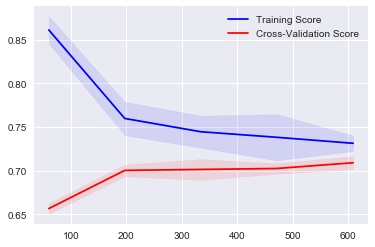

In [8]:
train_sizes, train_scores, valid_scores = learning_curve(lr_best, 
                                                         X, y, 
                                                         train_sizes=np.linspace(0.1, 1, 5))

plot_learning_curve(train_sizes, train_scores, valid_scores)

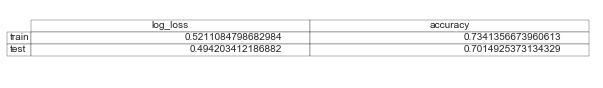

In [9]:
loss_accuracy_report(lr_best, (X, y), (X_tst, y_tst))

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_hyperparams = {'C': np.logspace(-3, 3, num=10)}

svc_best, svc_sores = random_grid_cv(X, y, SVC(probability=True), svc_hyperparams)

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(svc_best, 
                                                         X, y, 
                                                         cv=2, 
                                                         train_sizes=np.linspace(0.01, 1.0, 5))

plot_learning_curve(train_sizes, train_scores, valid_scores)

In [ ]:
loss_accuracy_report(svc_best, (X, y), (X_tst, y_tst))

# Neural Network

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout

In [ ]:
model_in = Input(shape=(X.shape[1], ))
a = Dense(int(X.shape[1]), activation='relu')(model_in)
a = Dropout(0.4)(a)
pred = Dense(1, activation='sigmoid')(a)

model = Model(inputs=model_in, outputs=pred)

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
nn_hist = model.fit(X, y, batch_size=32, epochs=30, validation_split=0.15)

In [ ]:
# Plot model history
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax1.set(title='Model Loss', xlabel='Epochs', ylabel='Loss')
ax1.plot(nn_hist.history['loss'], label='training loss')
ax1.plot(nn_hist.history['val_loss'], label='validation loss')
ax1.legend(loc='best')

ax2.set(title='Model Accuracy', xlabel='Epochs', ylabel='Accuracy')
ax2.plot(nn_hist.history['acc'], label='training accuracy')
ax2.plot(nn_hist.history['val_acc'], label='validation accuracy')
ax2.legend(loc='best')